In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
# CARGA DE DATOS
df = pd.read_csv("final_ozono.csv", parse_dates=["fecha"])

In [3]:
# Convertir columnas a numérico
# Conversión a float
for col in ["simulacion", "observacion", "tmp", "wsp"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.dtypes)
    
#df = df.dropna(subset=["simulacion", "observacion", "tmp", "wsp"])

fecha          datetime64[ns]
simulacion            float64
observacion           float64
tmp                   float64
wsp                   float64
dtype: object


In [4]:
# Eliminar filas con valores nulos
df = df.dropna(subset=["simulacion", "observacion", "tmp", "wsp"])
print(len(df)) #Eliminé 11% de datos finales (89%)

57226


5864
10.24709048334673


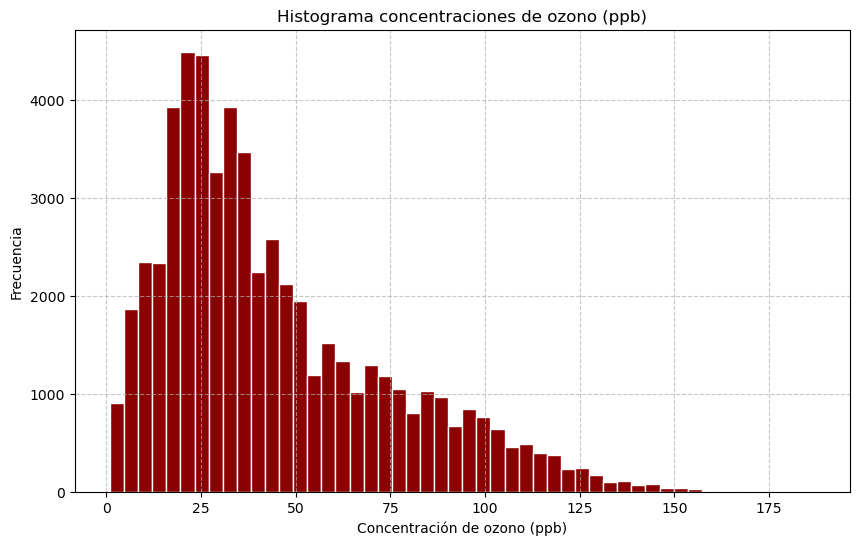

In [5]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df["observacion"], color='#8B0000', bins=50, edgecolor='white', alpha=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Histograma concentraciones de ozono (ppb)')
plt.xlabel('Concentración de ozono (ppb)')
plt.ylabel('Frecuencia')

conteo = (df['observacion'] > 90).sum()
porcentaje = conteo*100/len(df)
print(conteo)
print(porcentaje)

                fecha  simulacion  observacion    tmp   wsp      sesgo
0 2017-08-31 19:00:00   43.029999         32.0  17.43  2.89  11.029999
1 2017-08-31 20:00:00   31.389999         29.0  15.77  2.35   2.389999
2 2017-08-31 21:00:00   38.540001         23.0  15.11  2.17  15.540001
3 2017-08-31 22:00:00   36.020000         20.0  14.86  2.00  16.020000
4 2017-08-31 23:00:00   30.809999         19.0  14.98  1.16  11.809999


Text(20.85960113525391, 13535.0, 'Max Freq: 13533\n5.36-15.86')

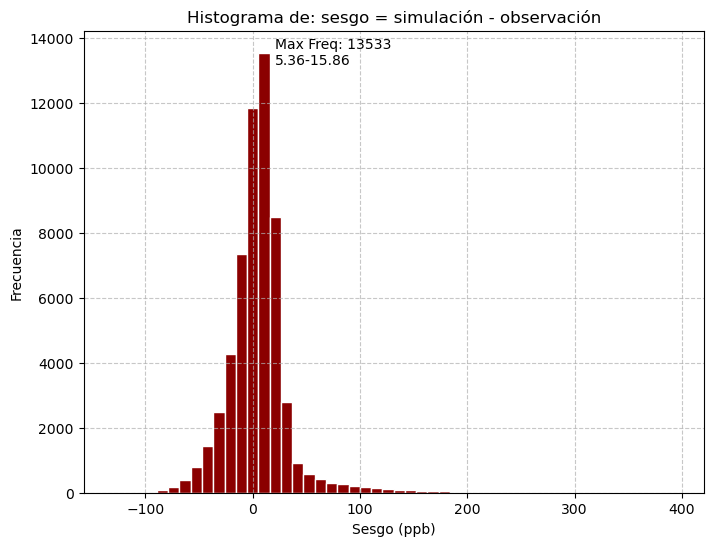

In [6]:
# Crear columna SESGO
df["sesgo"] = df["simulacion"] - df["observacion"]
print(df.head())


plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(df["sesgo"], color='#8B0000', bins=50, edgecolor='white', alpha=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Histograma de: sesgo = simulación - observación')
plt.xlabel('Sesgo (ppb)')
plt.ylabel('Frecuencia')

frecuencia_maxima = np.max(n)
indice_max = np.argmax(n)
intervalo_inicio = bins[indice_max]
intervalo_fin = bins[indice_max + 1]
plt.text(intervalo_fin+5, 
         frecuencia_maxima + 2, 
         f'Max Freq: {int(frecuencia_maxima)}\n{intervalo_inicio:.2f}-{intervalo_fin:.2f}', 
         ha='left', va='center', color='black') 

Text(-15.291199905395501, 538.0, 'Max Freq: 533\n-26.13--20.29')

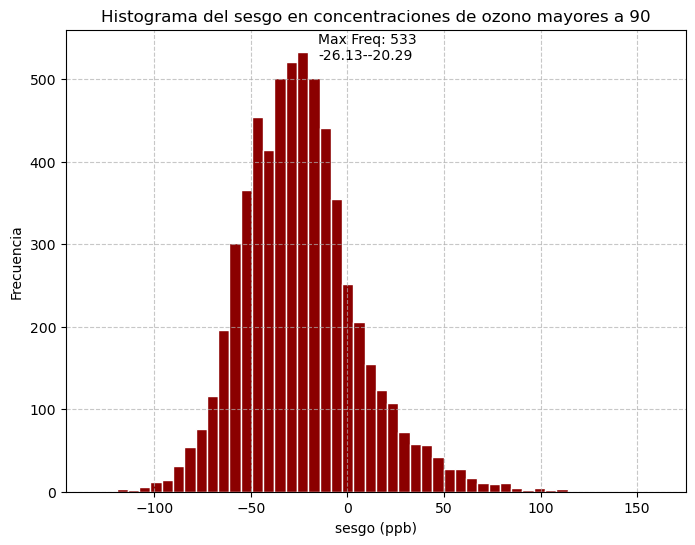

In [7]:
rango = pd.DataFrame()
for i in range(len(df)) :
    concentracion = df.iloc[i,2]
    if concentracion >= 90 :
        valor = df.iloc[i,5]
        rango.loc[i,0] = valor

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(rango, bins=50, color='#8B0000', edgecolor='white', alpha=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Histograma del sesgo en concentraciones de ozono mayores a 90')
plt.xlabel('sesgo (ppb)')
plt.ylabel('Frecuencia')

frecuencia_maxima = np.max(n)
indice_max = np.argmax(n)
intervalo_inicio = bins[indice_max]
intervalo_fin = bins[indice_max + 1]
plt.text(intervalo_fin + 5, 
         frecuencia_maxima + 5, 
         f'Max Freq: {int(frecuencia_maxima)}\n{intervalo_inicio:.2f}-{intervalo_fin:.2f}', 
         ha='left', va='center', color='black') 

Text(15.114000778198246, 11642.0, 'Max Freq: 11637\n0.98-10.11')

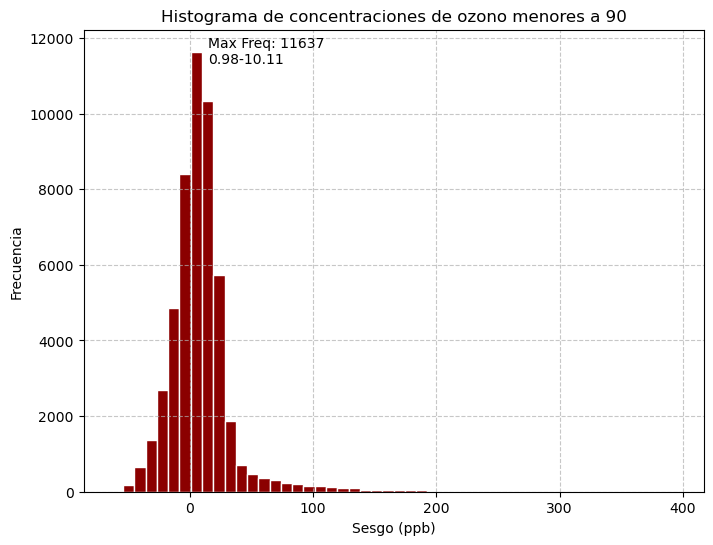

In [8]:
rango = pd.DataFrame()
for i in range(len(df)) :
    concentracion = df.iloc[i,2]
    if concentracion < 90 :
        valor = df.iloc[i,5]
        rango.loc[i,0] = valor
        
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(rango, bins=50, color='#8B0000', edgecolor='white', alpha=1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Histograma de concentraciones de ozono menores a 90')
plt.xlabel('Sesgo (ppb)')
plt.ylabel('Frecuencia')

frecuencia_maxima = np.max(n)
indice_max = np.argmax(n)
intervalo_inicio = bins[indice_max]
intervalo_fin = bins[indice_max + 1]
plt.text(intervalo_fin + 5, 
         frecuencia_maxima + 5, 
         f'Max Freq: {int(frecuencia_maxima)}\n{intervalo_inicio:.2f}-{intervalo_fin:.2f}', 
         ha='left', va='center', color='black') 

In [9]:
rmse = np.sqrt(mean_squared_error(df['observacion'], df['simulacion']))
mae = mean_absolute_error(df['observacion'], df['simulacion'])
r2 = r2_score(df['observacion'], df['simulacion'])

print("RMSE:", round(rmse,2))
print("MAE:", round(mae,2))
print("R2:", round(r2,2))

correlation_coefficient , pvalue = pearsonr(df['observacion'], df['simulacion'])
print(f"Coeficiente de correlación: {round(correlation_coefficient,2)}")

RMSE: 30.7
MAE: 19.42
R2: -0.03
Coeficiente de correlación: 0.54


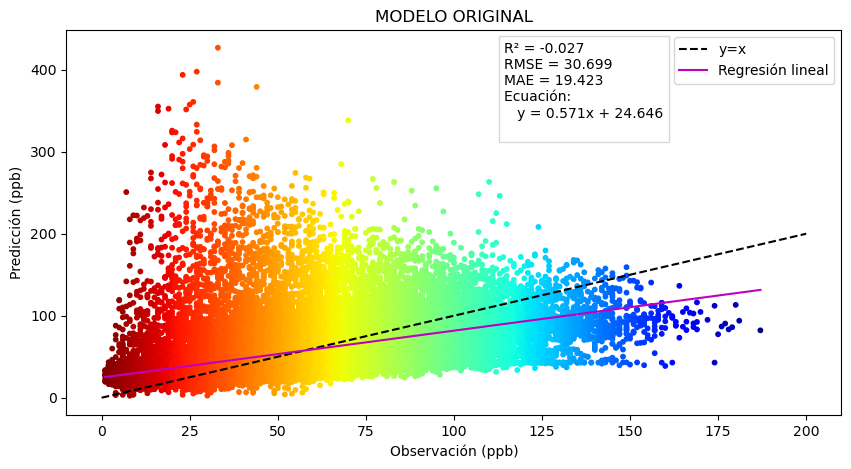

In [10]:
# Gráfico MODELO ORIGINAL 
# --- PRONÓSTICO DEL ICAyCC ---

#Regresión lineal
x = df["observacion"].values.reshape(-1, 1)
y = df["simulacion"].values
# Ajustar regresión lineal
model_lin = LinearRegression()
model_lin.fit(x, y)
# Parámetros de la recta
m = model_lin.coef_[0]
b = model_lin.intercept_
x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + b

plt.figure(figsize=(10,5))
plt.scatter(df["observacion"], df["simulacion"], alpha=1, s=10, c=df['observacion'], cmap='jet_r') #label="Modelo original"
plt.plot([0,200], [0,200], "k--", label="y=x")
plt.plot(x_line, y_line, "m-", label="Regresión lineal")
plt.xlabel("Observación (ppb)")
plt.ylabel("Predicción (ppb)")
plt.legend()
plt.title("MODELO ORIGINAL")
plt.text(
    0.565, 0.97,
    f"R² = {r2:.3f}\n"
    f"RMSE = {rmse:.3f}\n"
    f"MAE = {mae:.3f}\n"
    f"Ecuación: \n"
    f"   y = {m:.3f}x + {b:.3f}\n",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.3, edgecolor="gray")
)

plt.show()

In [11]:
# VARIABLES
# --- Transformación de fecha en senos y cosenos --- 

# Obtener el número de hora (0 - 23)
df["hora"] = df["fecha"].dt.hour

# Obtener el número de día
df["dia"] = df["fecha"].dt.day

# Obtener el número de mes (1-12)
df["mes"] = df["fecha"].dt.month

df["year"] = df["fecha"].dt.year

#Transformar a seno y coseno (perido = 24) ** HORA
df['hora_sin'] = np.sin(2 * np.pi * df['hora'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora'] / 24)

#Transformar a seno y coseno (perido = 31) ** DÍA DEL AÑO
df['dia_sin'] = np.sin(2 * np.pi * df['dia'] / 365)
df['dia_cos'] = np.cos(2 * np.pi * df['dia'] / 365)

#Transformar a seno y coseno (perido = 12) ** MES
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

print(df)

X = df[["simulacion", "tmp", "wsp", 'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos']] # Características / VARIABLES DE ENTRADA
y = df["sesgo"] # Variable objetivo / VARIABLE DE SALIDA

                    fecha  simulacion  observacion    tmp      wsp      sesgo  \
0     2017-08-31 19:00:00   43.029999         32.0  17.43  2.89000  11.029999   
1     2017-08-31 20:00:00   31.389999         29.0  15.77  2.35000   2.389999   
2     2017-08-31 21:00:00   38.540001         23.0  15.11  2.17000  15.540001   
3     2017-08-31 22:00:00   36.020000         20.0  14.86  2.00000  16.020000   
4     2017-08-31 23:00:00   30.809999         19.0  14.98  1.16000  11.809999   
...                   ...         ...          ...    ...      ...        ...   
64394 2025-04-30 20:00:00   53.070000         56.0  21.94  2.90000  -2.930000   
64395 2025-04-30 21:00:00   72.200000         52.0  19.77  3.55625  20.200000   
64396 2025-04-30 22:00:00   57.530000         53.0  18.52  3.02500   4.530000   
64397 2025-04-30 23:00:00   55.770000         52.0  18.10  1.67500   3.770000   
64398 2025-05-01 00:00:00   60.580000         44.0  18.01  1.68125  16.580000   

       hora  dia  mes  year

In [12]:
# CREACIÓN DE SUBCONJUNTOS : 
# ** ENTRENAMIENTO Y PRUEBA ** 

train_idx = df["year"].between(2017, 2024)
#val_idx   = df["year"] == 2024
test_idx  = df["year"] == 2025

X_train, y_train = X[train_idx], y[train_idx]
#X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

In [13]:
# crear conjutnos de simulación, observación y sesgo UNICAMENTE del año 2025
# -- Para posteriormente comparar métricas --

sim25 = pd.DataFrame() # Conjunto de datos de simulación del ICAyCC del 2025
obs25 = pd.DataFrame() # Conjunto de datos de observación de RAMA del 2025
ses25 = pd.DataFrame() # Conjunto de datos de sesgo entre modelo ICAyCC y real del 2025
for i in range(len(df)) :
    year = df.iloc[i,9]
    if year == 2025 :
        obs = df.iloc[i,2]
        sim = df.iloc[i,1]
        ses = df.iloc[i,5]
        obs25.loc[i,0] = obs
        sim25.loc[i,0] = sim
        ses25.loc[i,0] = ses
#ses25

In [14]:
# Entrenar Random Forest (1) número de árboles=100

# Configuración
RF = RandomForestRegressor(
    n_estimators = 100,
    #criterion = 'absolute_error', #squared_error, friendman_mse, absolute_error
    max_depth = None ,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 1, #sqrt,log2,
    bootstrap = True,
)

#Aplicar
RF.fit(X_train, y_train) #RF.fit(X_train, y_train, sample_weight=weights_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# PREDICCIÓN DEL SESGO Y CORRECCIÓN 
# *** PARA CONJUTNO DE PRUEBA (2025)

sesgo_pred = RF.predict(X_test)

sim_corr_xtest=X_test['simulacion']-sesgo_pred


🌲 Importancia de variables:
simulacion    0.491030
tmp           0.165930
wsp           0.122156
hora_sin      0.083361
hora_cos      0.078647
mes_sin       0.032399
mes_cos       0.026477
dtype: float64


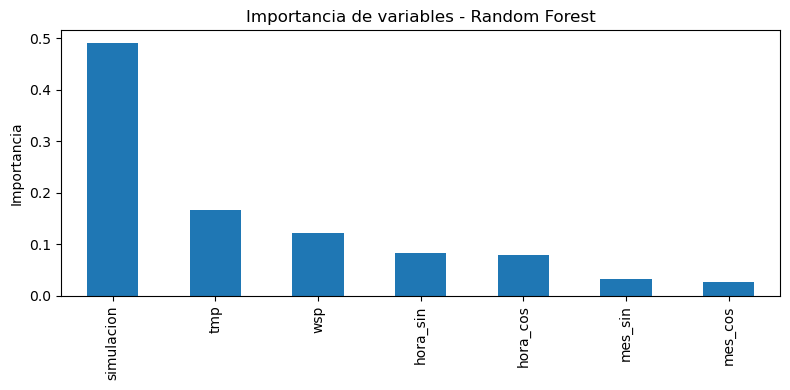

In [16]:
# IMPORTANCIA DE VARIABLES

importancias = pd.Series(
    RF.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("\n🌲 Importancia de variables:")
print(importancias)

plt.figure(figsize=(8, 4))
importancias.plot(kind="bar")
plt.title("Importancia de variables - Random Forest")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()


In [24]:
# MÉTRICAS POR CONJUNTO
rmse_modelo = np.sqrt(mean_squared_error(obs25, sim25))
mae_modelo = mean_absolute_error(obs25, sim25)
r2_modelo = r2_score(obs25, sim25)

print("\n MÉTRICAS MODELO ICAyCC")
print("RMSE=", round(rmse_modelo,2))
print("MAE=",  round(mae_modelo,2))
print("R²=",   round(r2_modelo, 2))

rmse_RF = np.sqrt(mean_squared_error(obs25, sim_corr_xtest))
mae_RF = mean_absolute_error(obs25, sim_corr_xtest)
r2_RF = r2_score(obs25, sim_corr_xtest)

print("\n MÉTRICAS MODELO RF")
print("RMSE=", round(rmse_RF,2))
print("MAE=",  round(mae_RF,2))
print("R²=",   round(r2_RF, 2))


 MÉTRICAS MODELO ICAyCC
RMSE= 22.88
MAE= 17.41
R²= 0.54

 MÉTRICAS MODELO RF
RMSE= 12.1
MAE= 9.29
R²= 0.87


/tmp/ipykernel_2075964/1555523817.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


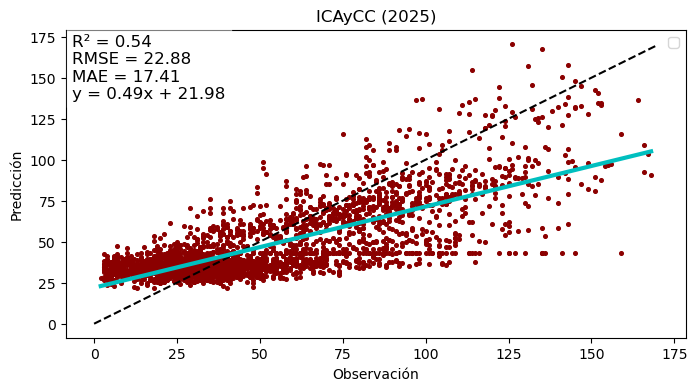

In [25]:
#GRÁFICO FINAL: OBSERVACIÓN vs SIMULACIÓN ICAyCC 2025
x = obs25.values.reshape(-1, 1)
y = sim25.values
# Ajustar regresión lineal
model_lin = LinearRegression()
model_lin.fit(x, y)
# Parámetros de la recta
m = model_lin.coef_[0]
m = m[0]
b = model_lin.intercept_
b = b[0]
x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + b

plt.figure(figsize=(8,4))
plt.scatter(obs25, sim25, color='#8B0000', s=7)
#plt.scatter(year25, sim_corr_xtest, alpha=0.6, label="Modelo corregido", color='#008B8B', s=10)
plt.plot([0,170], [0,170], "k--")
plt.plot(x_line, y_line, 'c-', linewidth=3)
plt.xlabel("Observación")
plt.ylabel("Predicción")
plt.legend()
plt.title("ICAyCC (2025)")
plt.text(
    0.01, 0.985,
    f"R² = {r2_modelo:.2f}\n"
    f"RMSE = {rmse_modelo:.2f}\n"
    f"MAE = {mae_modelo:.2f}\n"
    f"y = {m:.2f}x + {b:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.45, edgecolor="white")
)

plt.show()

/tmp/ipykernel_2075964/645213711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


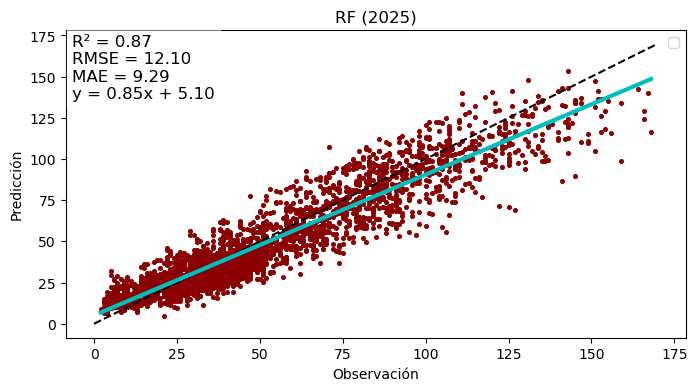

In [27]:
#GRÁFICO FINAL: OBSERVACIÓN vs SIMULACIÓN RF
x = obs25.values.reshape(-1, 1)
y = sim_corr_xtest.values
# Ajustar regresión lineal
model_lin = LinearRegression()
model_lin.fit(x, y)
# Parámetros de la recta
m = model_lin.coef_[0]
#m = m[0]
b = model_lin.intercept_
#b = b[0]
x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + b

plt.figure(figsize=(8,4))
plt.scatter(obs25, sim_corr_xtest, color='#8B0000', s=7)
#plt.scatter(year25, sim_corr_xtest, alpha=0.6, label="Modelo corregido", color='#008B8B', s=10)
plt.plot([0,170], [0,170], "k--")
plt.plot(x_line, y_line, 'c-', linewidth=3)
plt.xlabel("Observación")
plt.ylabel("Predicción")
plt.legend()
plt.title("RF (2025)")
plt.text(
    0.01, 0.985,
    f"R² = {r2_RF:.2f}\n"
    f"RMSE = {rmse_RF:.2f}\n"
    f"MAE = {mae_RF:.2f}\n"
    f"y = {m:.2f}x + {b:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.45, edgecolor="white")
)

plt.show()

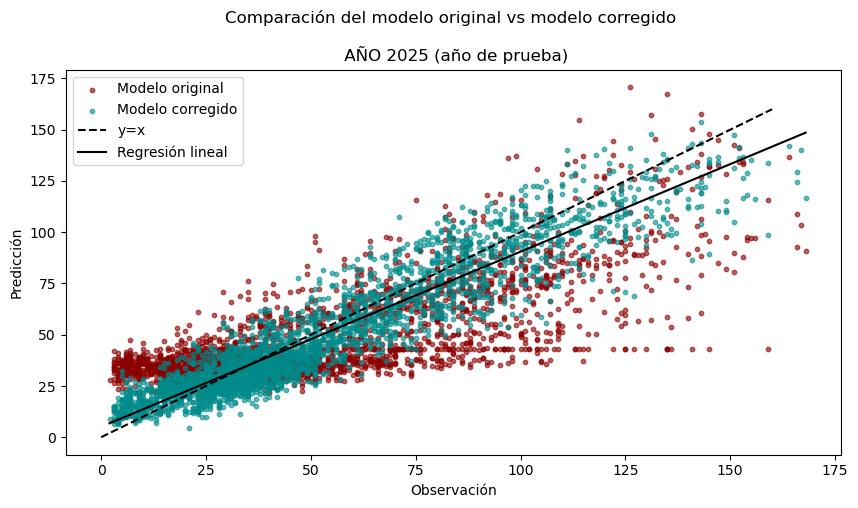

In [30]:
#GRÁFICO FINAL: OBSERVACIÓN vs CORREGIDO
x = obs25.values.reshape(-1, 1)
y = sim_corr_xtest.values
# Ajustar regresión lineal
model_lin = LinearRegression()
model_lin.fit(x, y)
# Parámetros de la recta
m = model_lin.coef_[0]
b = model_lin.intercept_
x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + b

plt.figure(figsize=(10,5))
plt.scatter(obs25, sim25, alpha=0.6, label="Modelo original", color='#8B0000', s=10)
plt.scatter(obs25, sim_corr_xtest, alpha=0.6, label="Modelo corregido", color='#008B8B', s=10)
plt.plot([0,160], [0,160], "k--", label="y=x")
plt.plot(x_line, y_line, 'k-', label="Regresión lineal")
plt.xlabel("Observación")
plt.ylabel("Predicción")
plt.legend()
plt.title("Comparación del modelo original vs modelo corregido \n\n AÑO 2025 (año de prueba)")

plt.show()

In [31]:
# Entrenar Random Forest (2) número de árboles=500

# Configuración
RF = RandomForestRegressor(
    n_estimators = 500,
    #criterion = 'absolute_error', #squared_error, friendman_mse, absolute_error
    max_depth = None ,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 1, #sqrt,log2,
    bootstrap = True,
)

#Aplicar
RF.fit(X_train, y_train) #RF.fit(X_train, y_train, sample_weight=weights_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
# PREDICCIÓN DEL SESGO Y CORRECCIÓN 
# *** PARA CONJUTNO DE PRUEBA (2025)

sesgo_pred = RF.predict(X_test)

sim_corr_xtest=X_test['simulacion']-sesgo_pred

In [33]:
# MÉTRICAS POR CONJUNTO
rmse_modelo = np.sqrt(mean_squared_error(obs25, sim25))
mae_modelo = mean_absolute_error(obs25, sim25)
r2_modelo = r2_score(obs25, sim25)

print("\n MÉTRICAS MODELO ICAyCC")
print("RMSE=", round(rmse_modelo,2))
print("MAE=",  round(mae_modelo,2))
print("R²=",   round(r2_modelo, 2))

rmse_RF = np.sqrt(mean_squared_error(obs25, sim_corr_xtest))
mae_RF = mean_absolute_error(obs25, sim_corr_xtest)
r2_RF = r2_score(obs25, sim_corr_xtest)

print("\n MÉTRICAS MODELO RF")
print("RMSE=", round(rmse_RF,2))
print("MAE=",  round(mae_RF,2))
print("R²=",   round(r2_RF, 2))


 MÉTRICAS MODELO ICAyCC
RMSE= 22.88
MAE= 17.41
R²= 0.54

 MÉTRICAS MODELO RF
RMSE= 12.02
MAE= 9.25
R²= 0.87


/tmp/ipykernel_2075964/1934945567.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


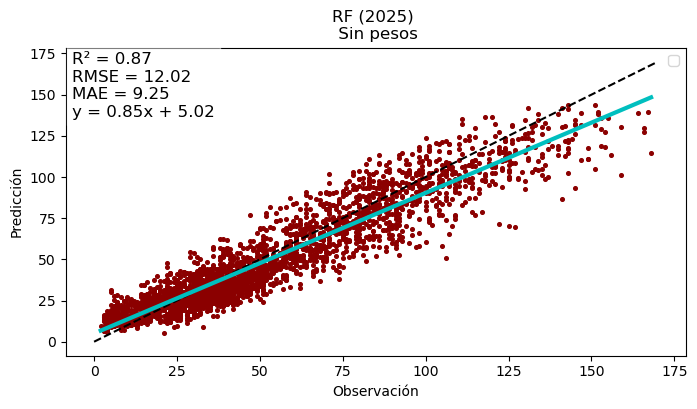

In [35]:
#GRÁFICO FINAL: OBSERVACIÓN vs SIMULACIÓN RF (2)
x = obs25.values.reshape(-1, 1)
y = sim_corr_xtest.values
# Ajustar regresión lineal
model_lin = LinearRegression()
model_lin.fit(x, y)
# Parámetros de la recta
m = model_lin.coef_[0]
#m = m[0]
b = model_lin.intercept_
#b = b[0]
x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + b

plt.figure(figsize=(8,4))
plt.scatter(obs25, sim_corr_xtest, color='#8B0000', s=7)
#plt.scatter(year25, sim_corr_xtest, alpha=0.6, label="Modelo corregido", color='#008B8B', s=10)
plt.plot([0,170], [0,170], "k--")
plt.plot(x_line, y_line, 'c-', linewidth=3)
plt.xlabel("Observación")
plt.ylabel("Predicción")
plt.legend()
plt.title("RF (2025) \n Sin pesos")
plt.text(
    0.01, 0.985,
    f"R² = {r2_RF:.2f}\n"
    f"RMSE = {rmse_RF:.2f}\n"
    f"MAE = {mae_RF:.2f}\n"
    f"y = {m:.2f}x + {b:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.45, edgecolor="white")
)

plt.show()

In [36]:
# Darle peso a concentraciones altas / sesgo menor a cero
weights_train = np.ones(len(y_train))
weights_train[y_train < 0] = 5

In [42]:
# Entrenar Random Forest (2) número de árboles=500

# Configuración
RF = RandomForestRegressor(
    n_estimators = 500,
    #criterion = 'absolute_error', #squared_error, friendman_mse, absolute_error
    max_depth = None ,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 1, #sqrt,log2,
    bootstrap = True,
)

#Aplicar
RF.fit(X_train, y_train, sample_weight=weights_train) #RF.fit(X_train, y_train, sample_weight=weights_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [43]:
# PREDICCIÓN DEL SESGO Y CORRECCIÓN 
# *** PARA CONJUTNO DE PRUEBA (2025)

sesgo_pred = RF.predict(X_test)

sim_corr_xtest=X_test['simulacion']-sesgo_pred

In [44]:
# MÉTRICAS POR CONJUNTO
rmse_modelo = np.sqrt(mean_squared_error(obs25, sim25))
mae_modelo = mean_absolute_error(obs25, sim25)
r2_modelo = r2_score(obs25, sim25)

print("\n MÉTRICAS MODELO ICAyCC")
print("RMSE=", round(rmse_modelo,2))
print("MAE=",  round(mae_modelo,2))
print("R²=",   round(r2_modelo, 2))

rmse_RF = np.sqrt(mean_squared_error(obs25, sim_corr_xtest))
mae_RF = mean_absolute_error(obs25, sim_corr_xtest)
r2_RF = r2_score(obs25, sim_corr_xtest)

print("\n MÉTRICAS MODELO RF")
print("RMSE=", round(rmse_RF,2))
print("MAE=",  round(mae_RF,2))
print("R²=",   round(r2_RF, 2))


 MÉTRICAS MODELO ICAyCC
RMSE= 22.88
MAE= 17.41
R²= 0.54

 MÉTRICAS MODELO RF
RMSE= 12.05
MAE= 9.28
R²= 0.87


/tmp/ipykernel_2075964/4292018203.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


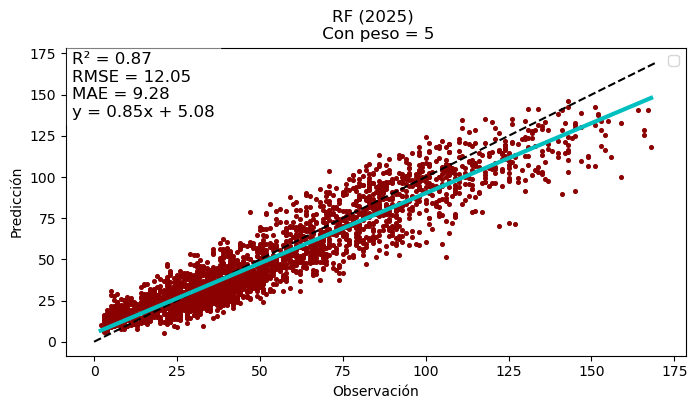

In [45]:
#GRÁFICO FINAL: OBSERVACIÓN vs SIMULACIÓN RF (2)
x = obs25.values.reshape(-1, 1)
y = sim_corr_xtest.values
# Ajustar regresión lineal
model_lin = LinearRegression()
model_lin.fit(x, y)
# Parámetros de la recta
m = model_lin.coef_[0]
#m = m[0]
b = model_lin.intercept_
#b = b[0]
x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + b

plt.figure(figsize=(8,4))
plt.scatter(obs25, sim_corr_xtest, color='#8B0000', s=7)
#plt.scatter(year25, sim_corr_xtest, alpha=0.6, label="Modelo corregido", color='#008B8B', s=10)
plt.plot([0,170], [0,170], "k--")
plt.plot(x_line, y_line, 'c-', linewidth=3)
plt.xlabel("Observación")
plt.ylabel("Predicción")
plt.legend()
plt.title("RF (2025) \n Con peso = 5")
plt.text(
    0.01, 0.985,
    f"R² = {r2_RF:.2f}\n"
    f"RMSE = {rmse_RF:.2f}\n"
    f"MAE = {mae_RF:.2f}\n"
    f"y = {m:.2f}x + {b:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.45, edgecolor="white")
)

plt.show()

In [46]:
# Darle peso a concentraciones altas / sesgo menor a -20
weights_train = np.ones(len(y_train))
weights_train[y_train < -20] = 5

In [47]:
# Entrenar Random Forest (2) número de árboles=500

# Configuración
RF = RandomForestRegressor(
    n_estimators = 500,
    #criterion = 'absolute_error', #squared_error, friendman_mse, absolute_error
    max_depth = None ,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 1, #sqrt,log2,
    bootstrap = True,
)

#Aplicar
RF.fit(X_train, y_train, sample_weight=weights_train) #RF.fit(X_train, y_train, sample_weight=weights_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
# PREDICCIÓN DEL SESGO Y CORRECCIÓN 
# *** PARA CONJUTNO DE PRUEBA (2025)

sesgo_pred = RF.predict(X_test)

sim_corr_xtest=X_test['simulacion']-sesgo_pred

In [49]:
# MÉTRICAS POR CONJUNTO
rmse_modelo = np.sqrt(mean_squared_error(obs25, sim25))
mae_modelo = mean_absolute_error(obs25, sim25)
r2_modelo = r2_score(obs25, sim25)

print("\n MÉTRICAS MODELO ICAyCC")
print("RMSE=", round(rmse_modelo,2))
print("MAE=",  round(mae_modelo,2))
print("R²=",   round(r2_modelo, 2))

rmse_RF = np.sqrt(mean_squared_error(obs25, sim_corr_xtest))
mae_RF = mean_absolute_error(obs25, sim_corr_xtest)
r2_RF = r2_score(obs25, sim_corr_xtest)

print("\n MÉTRICAS MODELO RF")
print("RMSE=", round(rmse_RF,2))
print("MAE=",  round(mae_RF,2))
print("R²=",   round(r2_RF, 2))


 MÉTRICAS MODELO ICAyCC
RMSE= 22.88
MAE= 17.41
R²= 0.54

 MÉTRICAS MODELO RF
RMSE= 12.08
MAE= 9.29
R²= 0.87


/tmp/ipykernel_2075964/4292018203.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


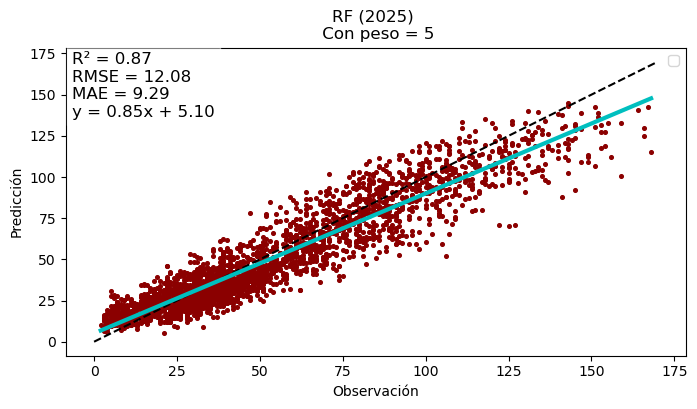

In [50]:
#GRÁFICO FINAL: OBSERVACIÓN vs SIMULACIÓN RF (2)
x = obs25.values.reshape(-1, 1)
y = sim_corr_xtest.values
# Ajustar regresión lineal
model_lin = LinearRegression()
model_lin.fit(x, y)
# Parámetros de la recta
m = model_lin.coef_[0]
#m = m[0]
b = model_lin.intercept_
#b = b[0]
x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + b

plt.figure(figsize=(8,4))
plt.scatter(obs25, sim_corr_xtest, color='#8B0000', s=7)
#plt.scatter(year25, sim_corr_xtest, alpha=0.6, label="Modelo corregido", color='#008B8B', s=10)
plt.plot([0,170], [0,170], "k--")
plt.plot(x_line, y_line, 'c-', linewidth=3)
plt.xlabel("Observación")
plt.ylabel("Predicción")
plt.legend()
plt.title("RF (2025) \n Con peso = 5")
plt.text(
    0.01, 0.985,
    f"R² = {r2_RF:.2f}\n"
    f"RMSE = {rmse_RF:.2f}\n"
    f"MAE = {mae_RF:.2f}\n"
    f"y = {m:.2f}x + {b:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.45, edgecolor="white")
)

plt.show()